<a href="https://colab.research.google.com/github/w-olszewski/Brain_MRI_segmentation/blob/main/U_NET_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#imported libraries
!curl -s -o colormap.txt https://raw.githubusercontent.com/thenineteen/Semiology-Visualisation-Tool/master/slicer/Resources/Color/BrainAnatomyLabelsV3_0.txt
import imageio
import multiprocessing
import torch
import torchio as tio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors
from imageio import imread
import glob
from pathlib import Path
import nibabel as nib
import enum
import torchvision
from tqdm import tqdm
from IPython import display
from scipy import stats
from torchmetrics.functional import dice

In [ ]:
# Accessing dataset

from google.colab import drive
drive.mount('/content/MyDrive')

datafiles = os.path.abspath('/content/MyDrive/MyDrive/Colab_Notebooks/UNET/MICCAI_MultiAtlasChallenge2012_corrected/Training')

datafiles_dir = Path(datafiles)

%cd /content/MyDrive/MyDrive/Colab_Notebooks/UNET/MICCAI_MultiAtlasChallenge2012_corrected/Training

!tree -d {datafiles_dir}


In [ ]:
# Configuration

seed = 42
training_split_ratio = 0.8

random.seed(seed)
torch.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'
num_workers = multiprocessing.cpu_count()
plt.rcParams['figure.figsize'] = 12, 6

In [ ]:
# Training dataset

images_dir = datafiles_dir / 'Images'
masks_dir = datafiles_dir / 'SegmentMaps'
image_paths = sorted(images_dir.glob('*.nii'))
mask_paths = sorted(masks_dir.glob('*.nii'))
assert len(image_paths) == len(mask_paths)

subjects = []
for (image_path, mask_path) in zip(image_paths, mask_paths):
    subject = tio.Subject(
        mri=tio.ScalarImage(image_path),
        brain=tio.LabelMap(mask_path),
    )

    subjects.append(subject)
dataset = tio.SubjectsDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')


In [ ]:
# Testing dataset

test_dir = datafiles_dir / '../Testing'

test_paths = sorted(test_dir.glob('*.nii'))

test_list = []
for test_path in test_paths:
    test_subject = tio.Subject(mri=tio.ScalarImage(test_path))

    test_list.append(test_subject)
testing_dataset = tio.SubjectsDataset(test_list)
print('Validation dataset size:', len(testing_dataset), 'subjects')


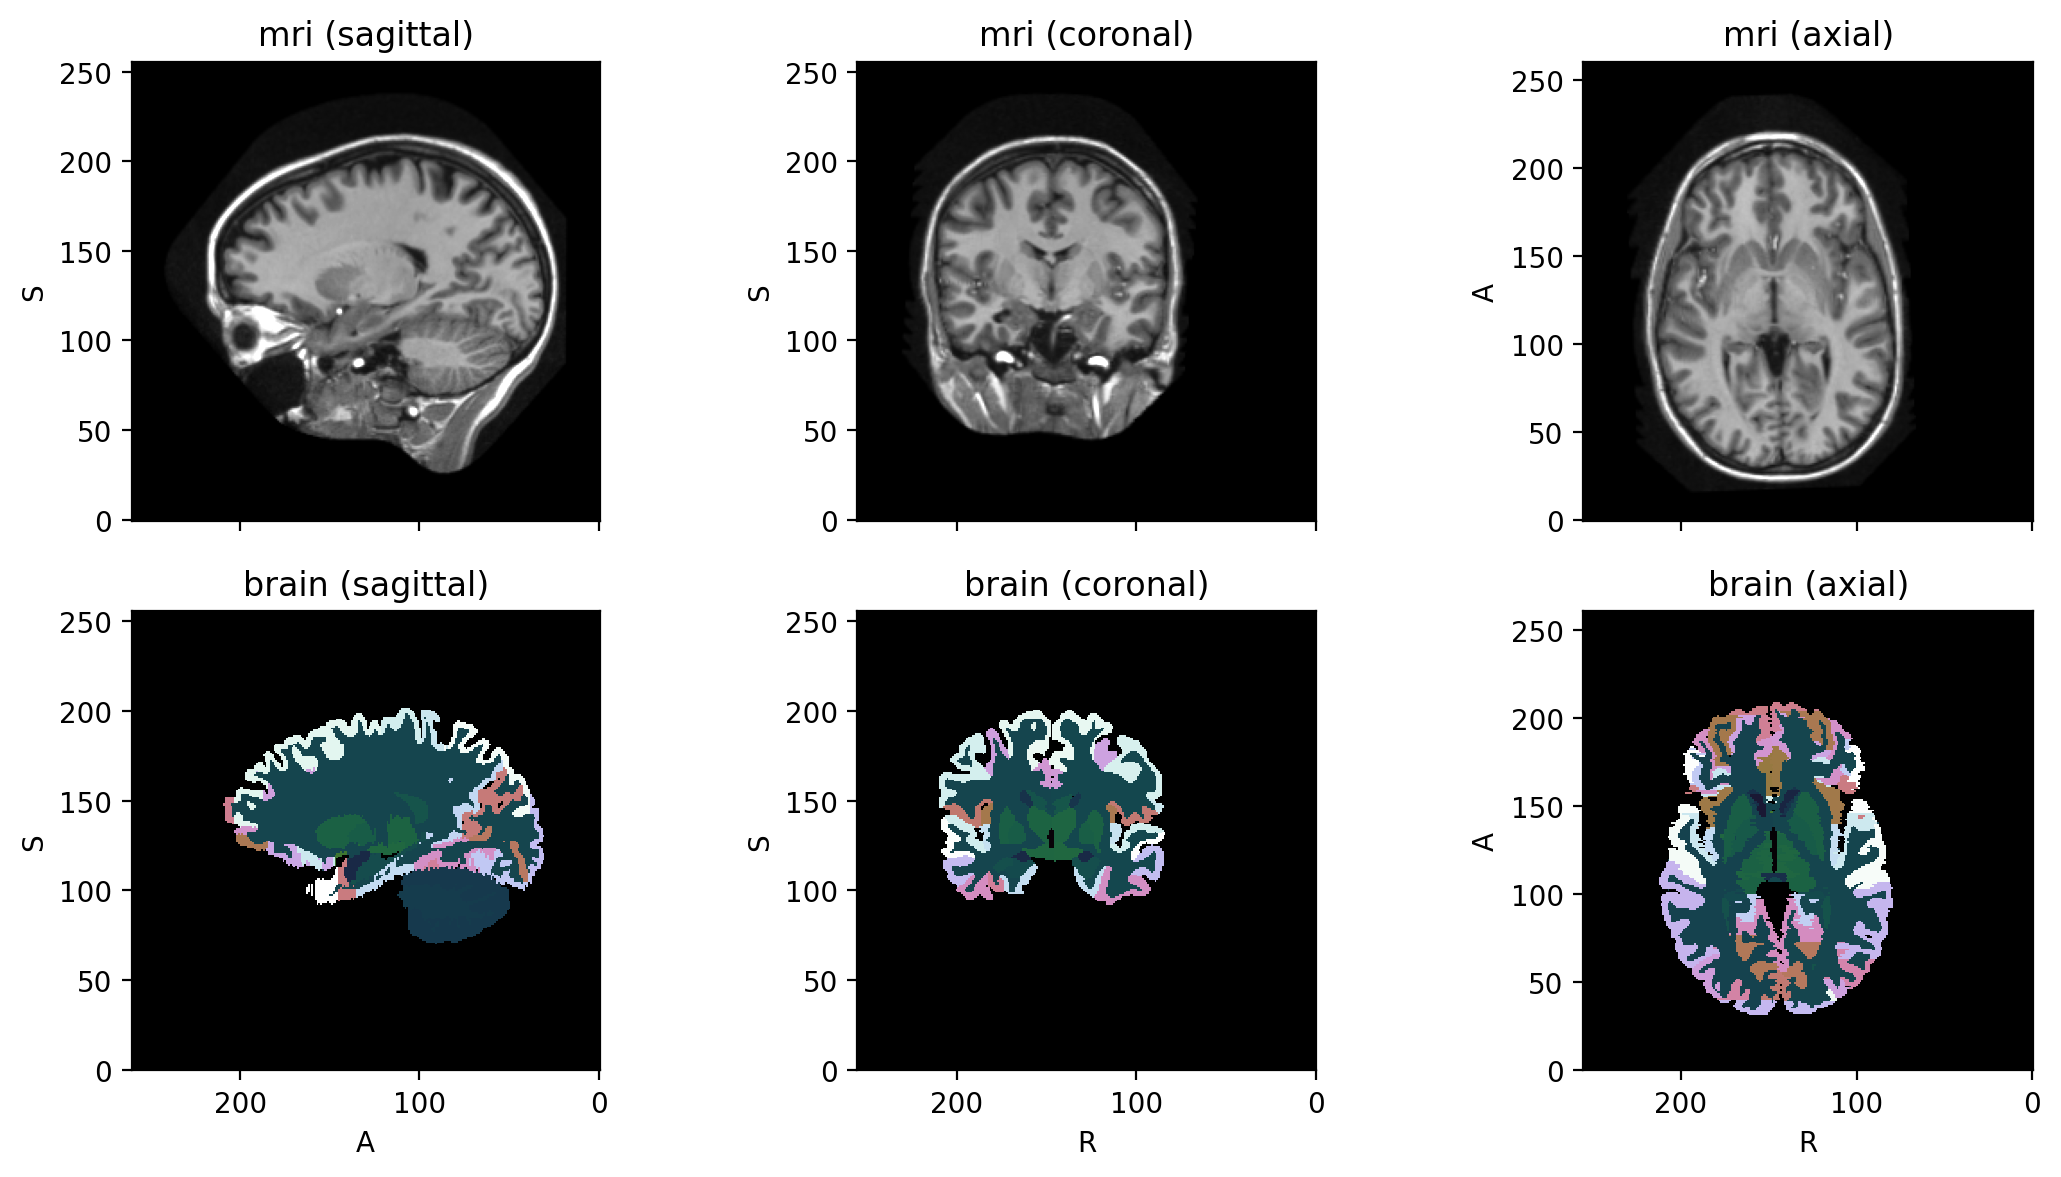

Subject(Keys: ('mri', 'brain'); images: 2)
ScalarImage(shape: (1, 256, 256, 261); spacing: (1.00, 1.00, 1.00); orientation: LIA+; dtype: torch.IntTensor; memory: 65.2 MiB)
LabelMap(shape: (1, 256, 256, 261); spacing: (1.00, 1.00, 1.00); orientation: LIA+; dtype: torch.ShortTensor; memory: 32.6 MiB)


In [ ]:
one_subject = dataset[1]
one_subject.plot()

print(one_subject)
print(one_subject.mri)
print(one_subject.brain)

100%|██████████| 15/15 [08:54<00:00, 35.64s/it]


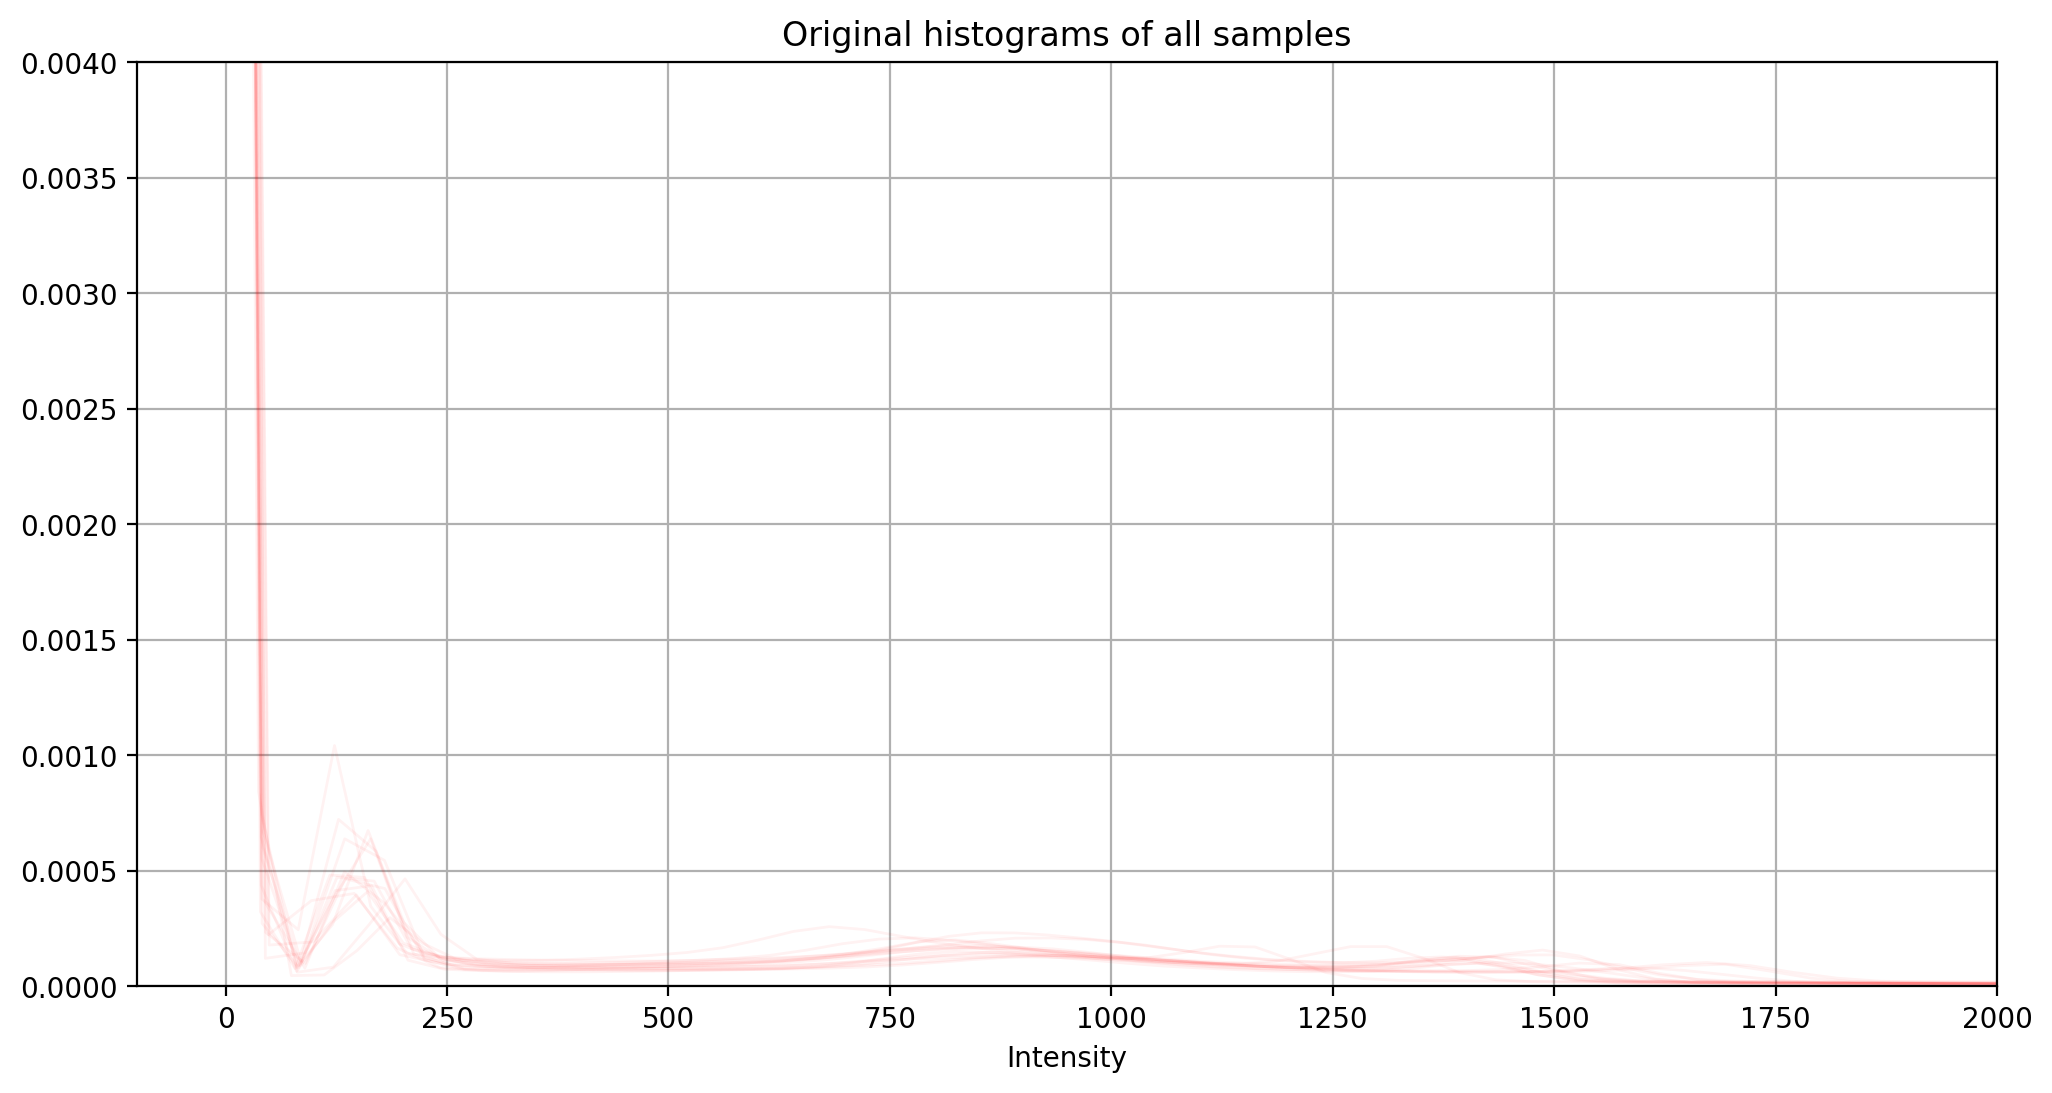

In [ ]:
# Training the histogram

paths = image_paths
compute_histograms = True

def plot_histogram(axis, tensor, num_positions=100, label=None, alpha=0.05, color=None):
    values = tensor.numpy().ravel()
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
    if label is not None:
        kwargs['label'] = label
    axis.plot(positions, histogram, **kwargs)

if compute_histograms:
    fig, ax = plt.subplots(dpi=100)
    for path in tqdm(paths):
        tensor = tio.ScalarImage(path).data
        color = 'red'
        plot_histogram(ax, tensor, color=color)
    ax.set_xlim(-100, 2000)
    ax.set_ylim(0, 0.004);
    ax.set_title('Original histograms of all samples')
    ax.set_xlabel('Intensity')
    ax.grid()
    graph = None
else:
    graph = None

In [ ]:
histogram_landmarks_path = 'landmarks.npy'

landmarks = tio.HistogramStandardization.train(
    image_paths,
    output_path=histogram_landmarks_path,
)

np.set_printoptions(suppress=True, precision=3)
print('\nTrained landmarks:', landmarks)

100%|██████████| 15/15 [08:59<00:00, 35.99s/it]


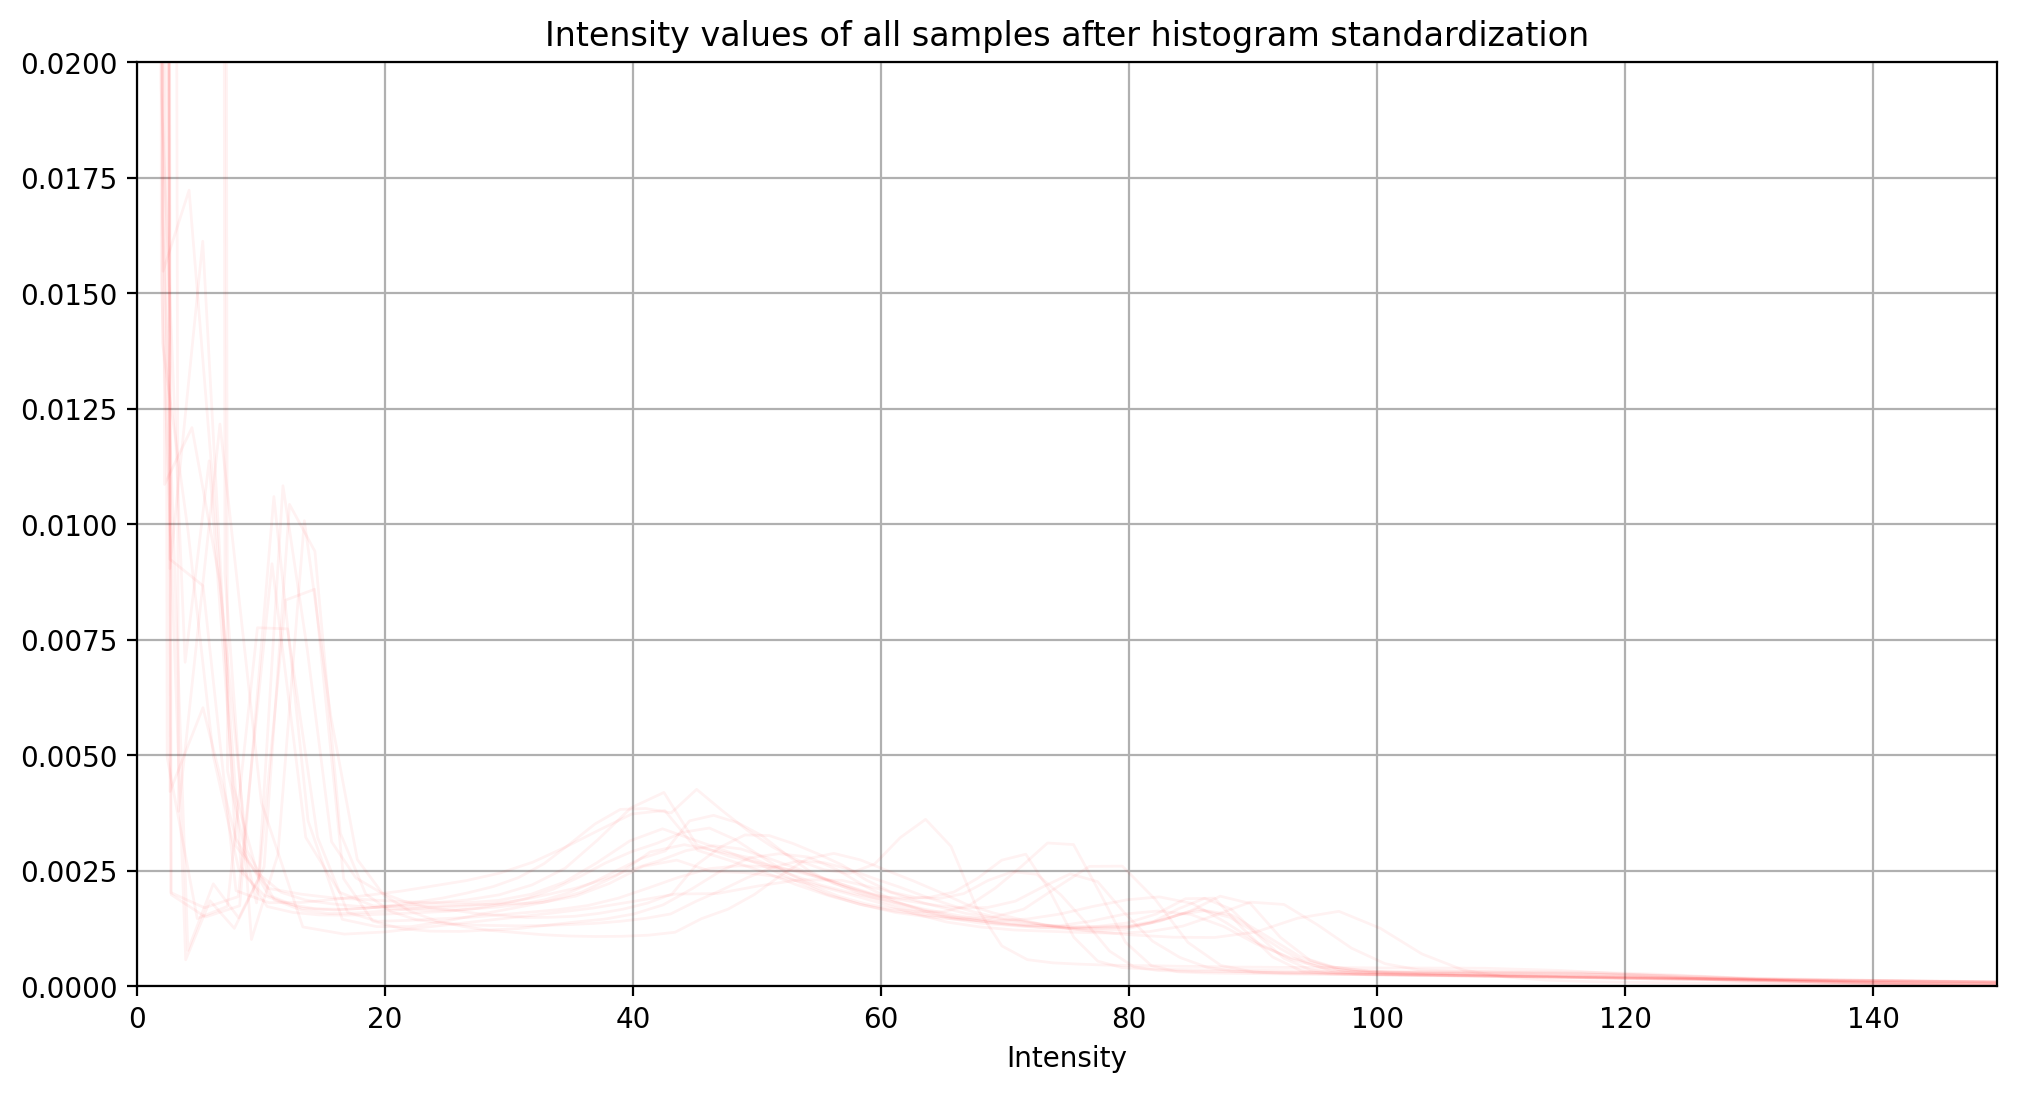

In [ ]:
landmarks_dict = {'mri': landmarks}
histogram_transform = tio.HistogramStandardization(landmarks_dict)

if compute_histograms:
    fig, ax = plt.subplots(dpi=100)
    for i ,sample in enumerate(tqdm(dataset)):
        standard = histogram_transform(sample)
        tensor = standard.mri.data
        path = str(sample.mri.path)
        if 'HH' in path: color = 'red'
        elif 'Guys' in path: color = 'green'
        elif 'IOP' in path: color = 'blue'
        plot_histogram(ax, tensor, color=color)
    ax.set_xlim(0, 150)
    ax.set_ylim(0, 0.02)
    ax.set_title('Intensity values of all samples after histogram standardization')
    ax.set_xlabel('Intensity')
    ax.grid()
    graph = None

else:
    graph = None

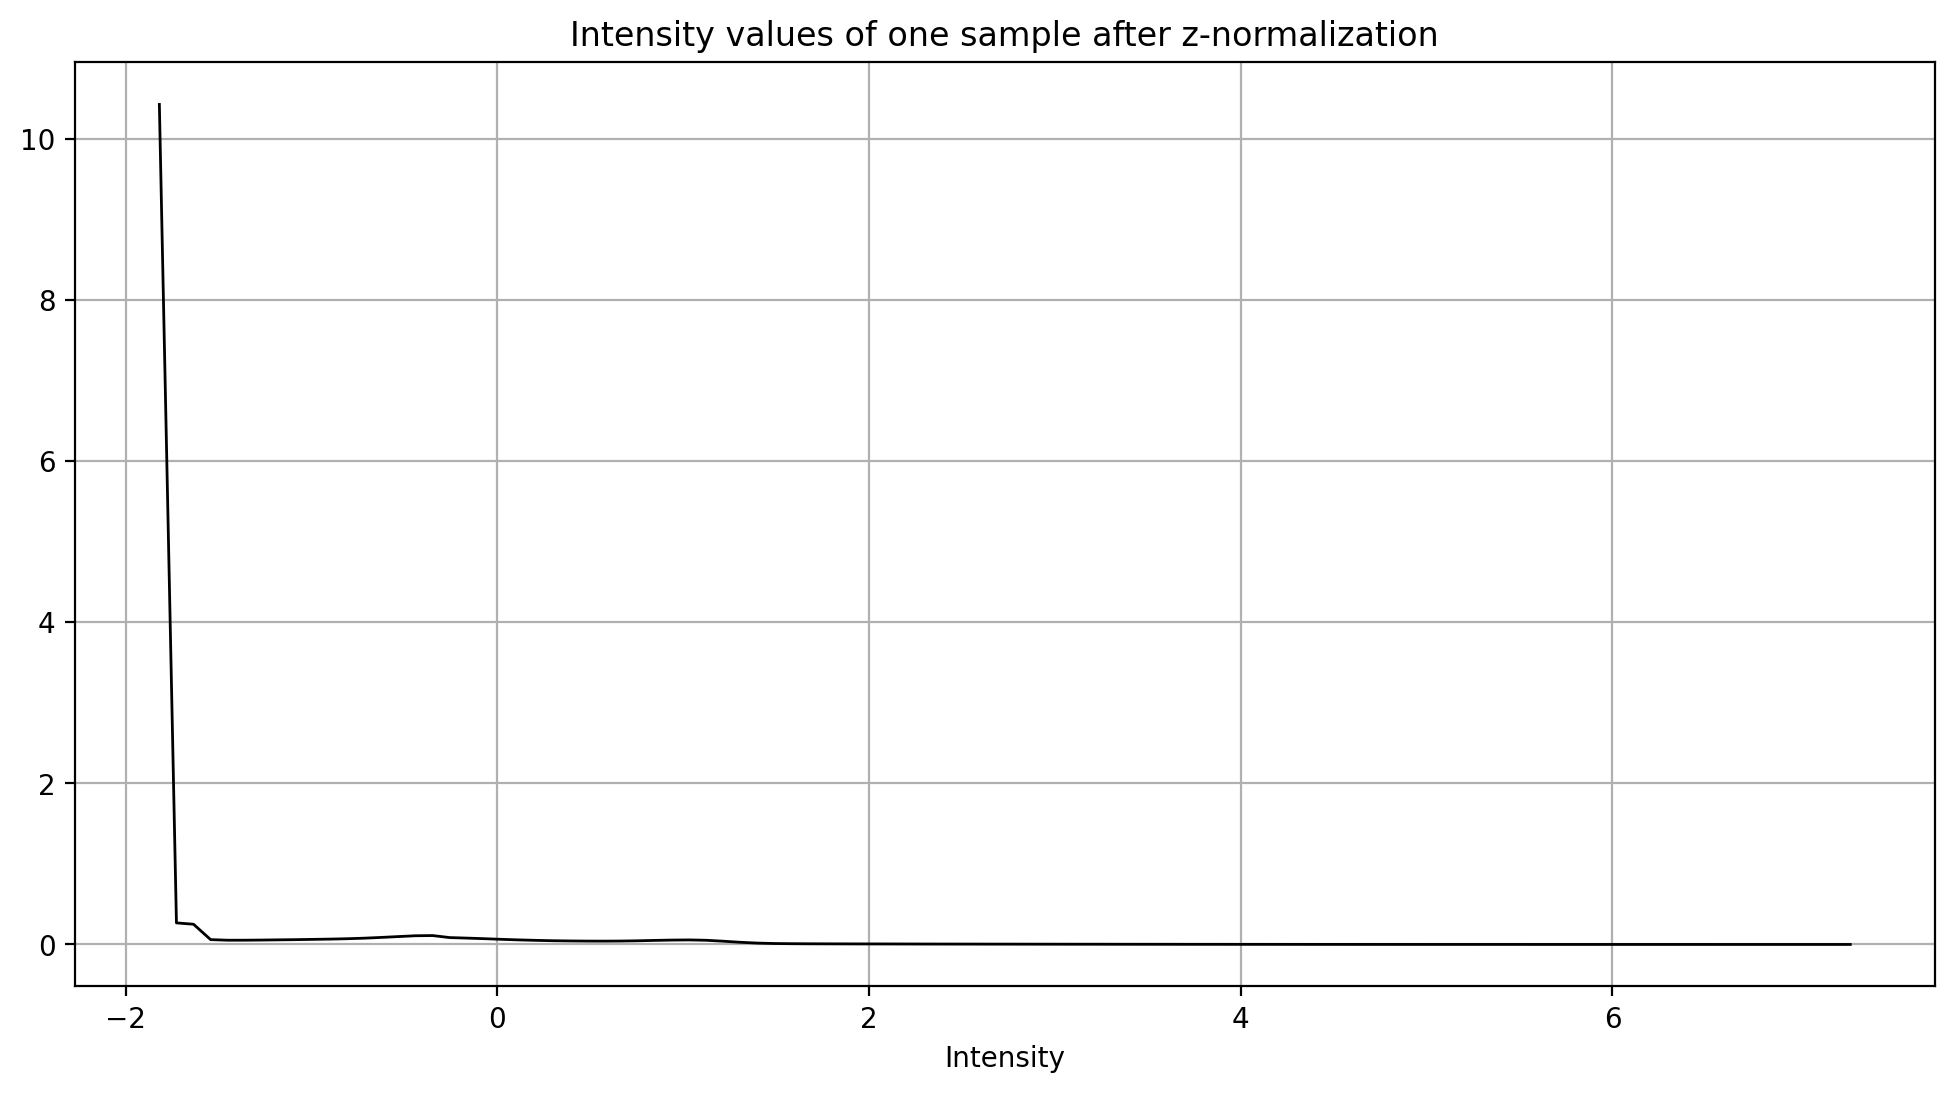

In [ ]:
znorm_transform = tio.ZNormalization(masking_method=tio.ZNormalization.mean)

sample = dataset[0]
transform = tio.Compose([histogram_transform, znorm_transform])
znormed = transform(sample)

fig, ax = plt.subplots(dpi=100)
plot_histogram(ax, znormed.mri.data, label='Z-normed', alpha=1)
ax.set_title('Intensity values of one sample after z-normalization')
ax.set_xlabel('Intensity')
ax.grid()

In [ ]:
# Transformations

training_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad((48, 56, 48)),
    tio.RandomMotion(p=0.2),
    tio.HistogramStandardization({'mri': landmarks}),
    tio.RandomBiasField(p=0.3),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.RandomNoise(p=0.5),
    tio.RandomFlip(),
    tio.OneOf({
        tio.RandomAffine(): 0.8,
        tio.RandomElasticDeformation(): 0.2,
    }),
    tio.OneHot(),
])

validation_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad((48, 56, 48)),
    tio.HistogramStandardization({'mri': landmarks}),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.OneHot(),
])

testing_transform = tio.Compose([
    tio.HistogramStandardization({'mri': landmarks}),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
])

training_split_ratio = 0.8

num_subjects = len(dataset)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_subjects = num_training_subjects, num_validation_subjects
training_subjects, validation_subjects = torch.utils.data.random_split(subjects, num_split_subjects)

training_set = tio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = tio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

testing_set = tio.SubjectsDataset(
    testing_dataset, transform=testing_transform)


print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

In [ ]:
#@title
# U-NET model
# 4 convolution layers

class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=208, num_filter=32):
        super(UNet, self).__init__()

        # Encoder path

        n = num_filter  # 32
        self.conv1 = nn.Sequential(
            nn.Conv3d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
            nn.Conv3d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU()
        )

        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)

        n = n * 2  # 64
        self.conv2 = nn.Sequential(
            nn.Conv3d(int(n / 2), n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
            nn.Conv3d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU()
        )

        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)

        n = n * 2  # 128
        self.conv3 = nn.Sequential(
            nn.Conv3d(int(n / 2), n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
            nn.Conv3d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU()
        )

        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)

        n = n * 2  # 256
        self.conv4 = nn.Sequential(
            nn.Conv3d(int(n / 2), n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
            nn.Conv3d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU()
        )

        self.drop = nn.Dropout(p=0.5)

       # Decoder path

        n = int(n / 2)  # 128
        self.up3 = nn.ConvTranspose3d(n * 2, n, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.conv_up3 = nn.Sequential(
            nn.Conv3d(n * 2, n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
            nn.Conv3d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU()
        )

        n = int(n / 2)  # 64
        self.up2 = nn.ConvTranspose3d(n * 2, n, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.conv_up2 = nn.Sequential(
            nn.Conv3d(n * 2, n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
            nn.Conv3d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU()
        )

        n = int(n / 2)  # 32
        self.up1 = nn.ConvTranspose3d(n * 2, n, kernel_size=3, stride=2, padding=1, output_padding=1)

        self.conv_up1 = nn.Sequential(
            nn.Conv3d(n * 2, n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
            nn.Conv3d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm3d(n),
            nn.ReLU(),
        )

        self.out = nn.Conv3d(n, output_channel, kernel_size=1, padding=0)

    def forward(self, x):

        x = self.conv1(x)
        conv1_skip = x

        x = self.pool1(x)

        x = self.conv2(x)
        conv2_skip = x

        x = self.pool2(x)

        x = self.conv3(x)
        conv3_skip = x

        x = self.pool3(x)

        x = self.conv4(x)

        x = self.drop(x)

        x = self.up3(x)
        x = self.conv_up3(torch.cat([conv3_skip, x], dim=1))

        x = self.up2(x)
        x = self.conv_up2(torch.cat([conv2_skip, x], dim=1))

        x = self.up1(x)
        x = self.conv_up1(torch.cat([conv1_skip, x], dim=1))

        x = self.out(x)

        return x


In [ ]:
# Training units

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4
num_classes = 208


def prepare_batch(batch, device):
    inputs = batch['mri'][tio.DATA].to(device)
    targets = batch['brain'][tio.DATA].to(device)
    return inputs, targets

def get_model_and_optimizer(device):
    model = UNet(input_channel=1, output_channel=num_classes, num_filter=32).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)
    return model, optimizer


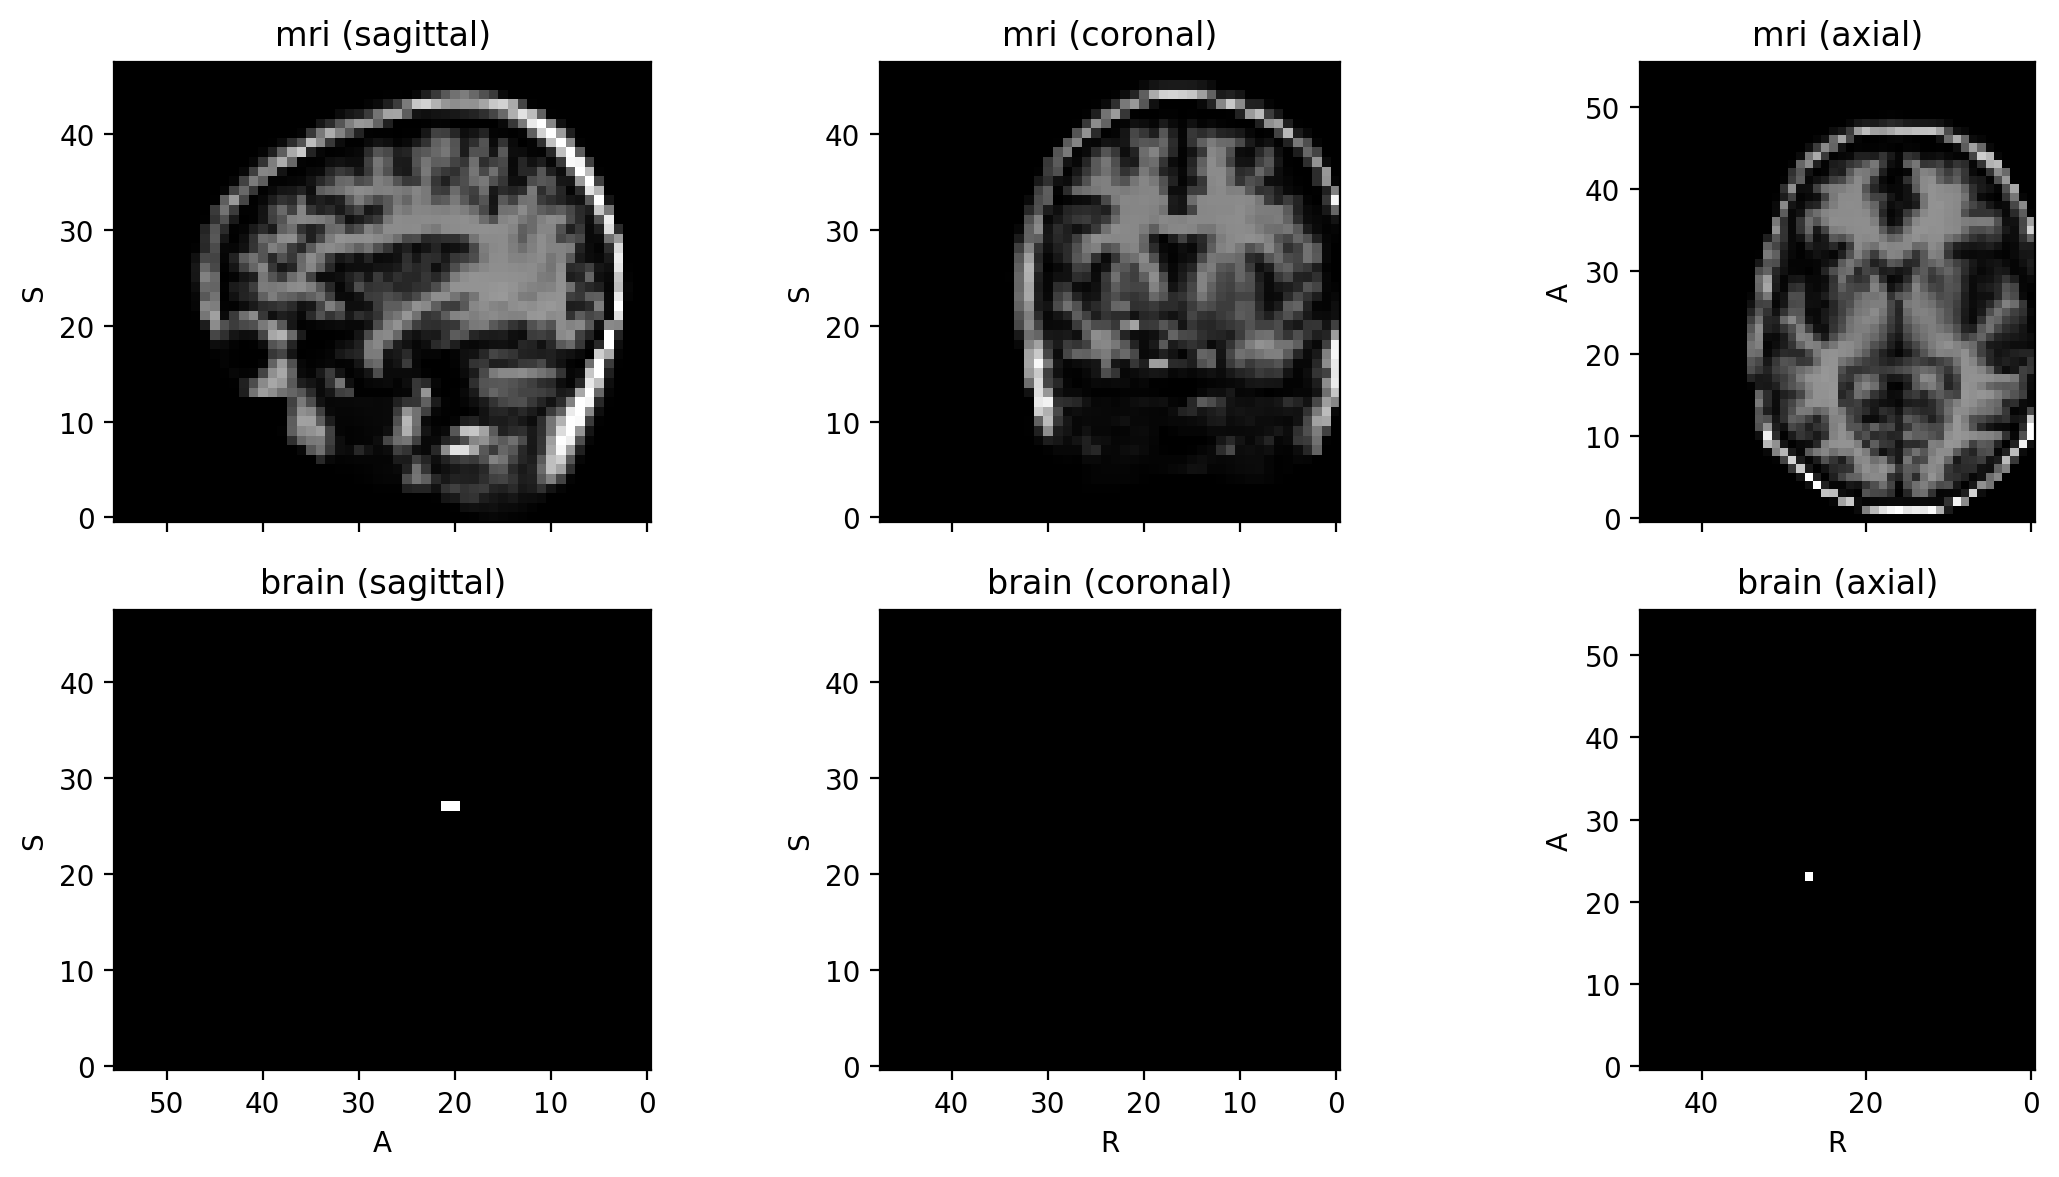

ScalarImage(shape: (1, 48, 56, 48); spacing: (4.00, 4.00, 4.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 504.0 KiB)
LabelMap(shape: (208, 48, 56, 48); spacing: (4.00, 4.00, 4.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 102.4 MiB)


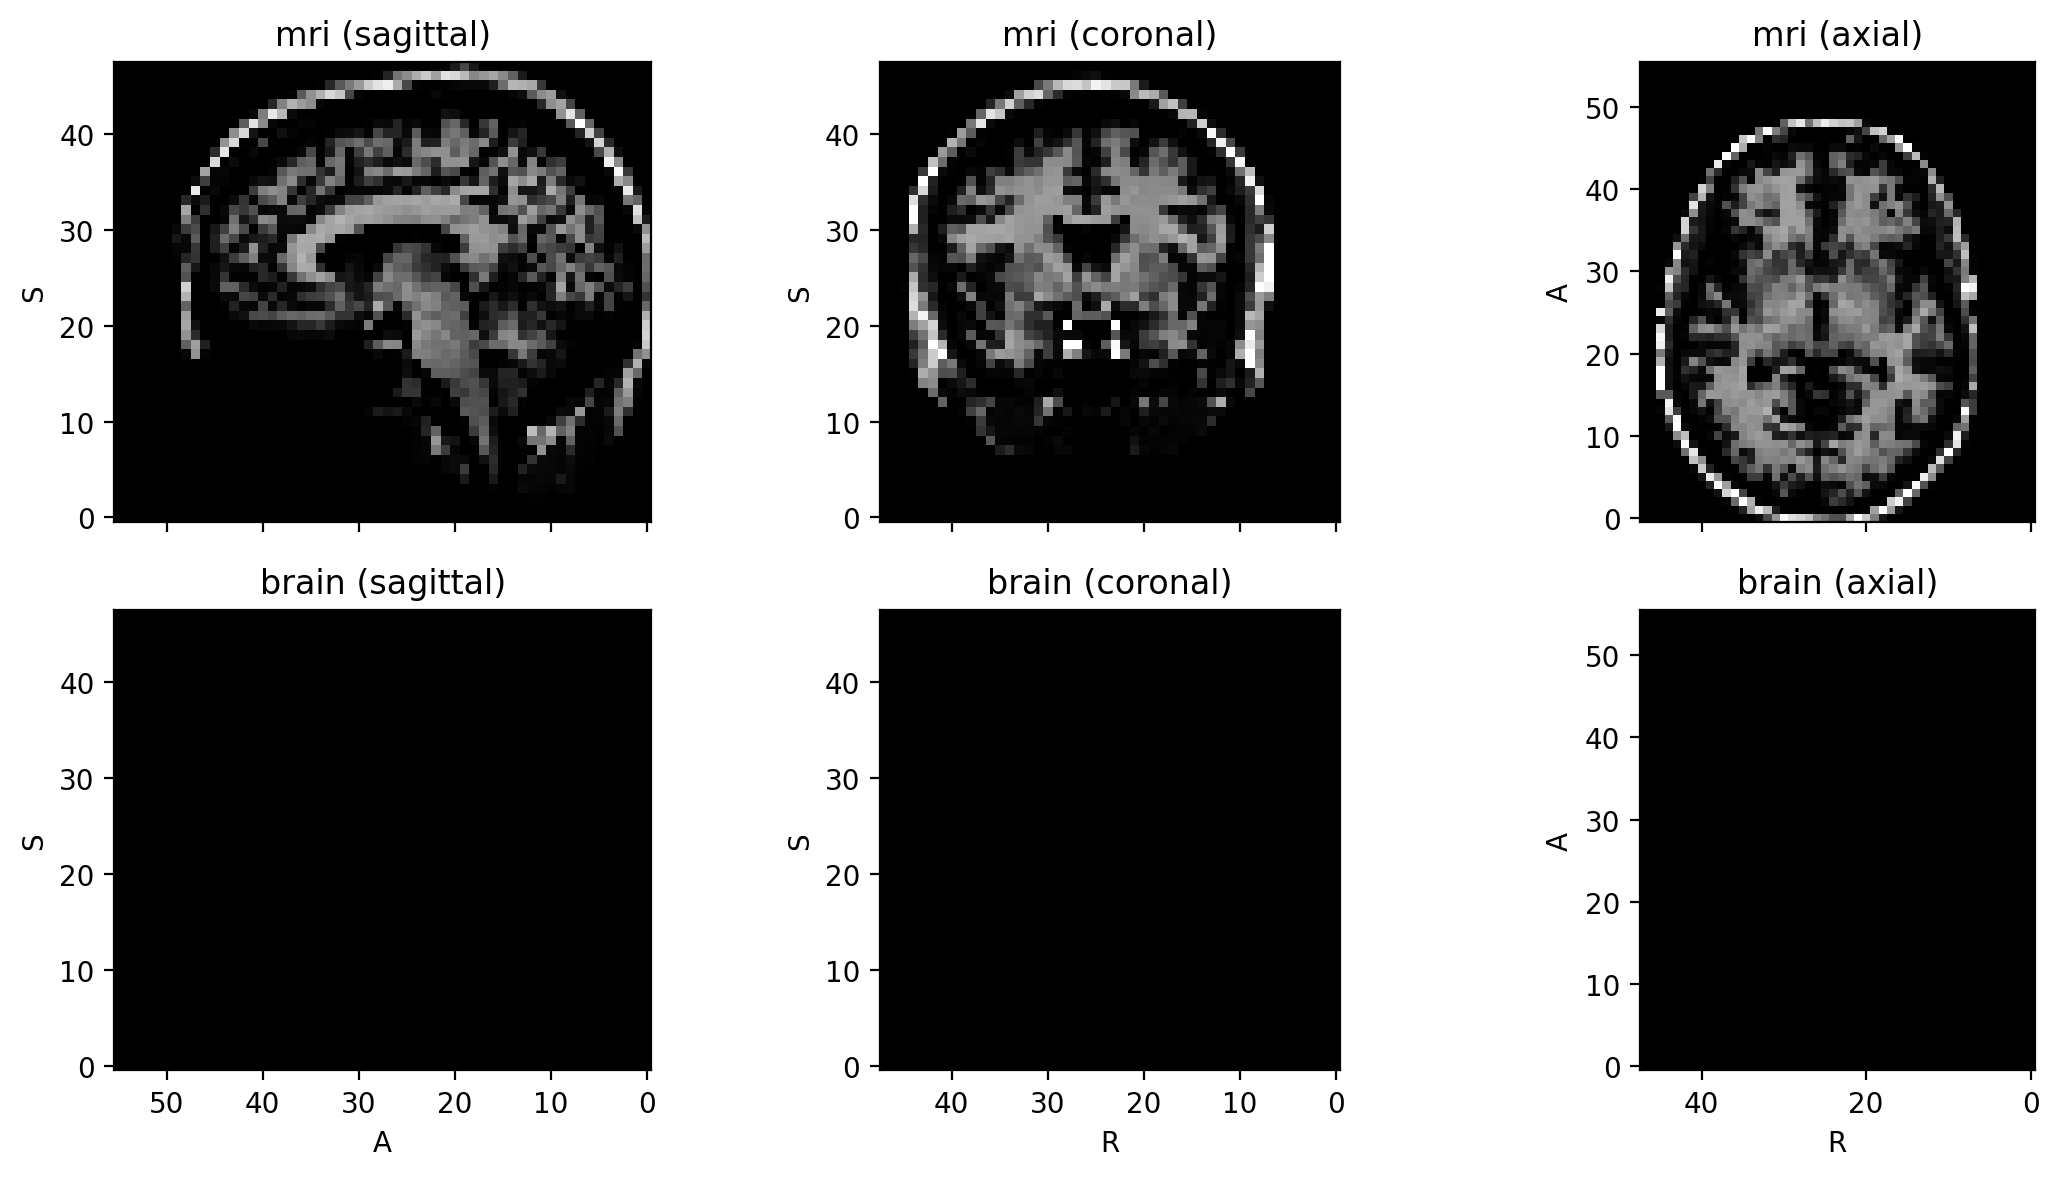

ScalarImage(shape: (1, 48, 56, 48); spacing: (4.00, 4.00, 4.00); orientation: RAS+; dtype: torch.FloatTensor; memory: 504.0 KiB)
LabelMap(shape: (208, 48, 56, 48); spacing: (4.00, 4.00, 4.00); orientation: RAS+; dtype: torch.ShortTensor; memory: 51.2 MiB)


In [ ]:
training_instance = training_set[4]  # transform is applied inside SubjectsDataset
training_instance.plot()
print(training_instance.mri)
print(training_instance.brain)

validation_instance = validation_set[1]  # transform is applied inside SubjectsDataset
validation_instance.plot()
print(validation_instance.mri)
print(validation_instance.brain)

In [ ]:
training_batch_size = 32
validation_batch_size = 2 * training_batch_size
num_workers = multiprocessing.cpu_count()

training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=num_workers,
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
    num_workers=num_workers,
)


In [ ]:
# Patch-based training


patch_size = 24
samples_per_volume = 5
max_queue_length = 300
sampler = tio.data.UniformSampler(patch_size)

patches_training_set = tio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=True,
    shuffle_patches=True,
)

patches_validation_set = tio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader_patches = torch.utils.data.DataLoader(
    patches_training_set, batch_size=training_batch_size)

validation_loader_patches = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=validation_batch_size)

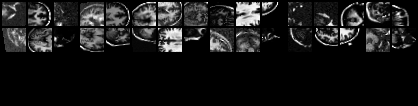

In [ ]:
# Patch-based training

one_batch = next(iter(training_loader_patches))
k = int(patch_size // 4)
batch_mri = one_batch['mri'][tio.DATA][..., k]
batch_label = one_batch['brain'][tio.DATA][:, 207:, ..., k]
slices = torch.cat((batch_mri, batch_label))
image_path = 'batch_patches.png'
torchvision.utils.save_image(
    slices,
    image_path,
    nrow=training_batch_size//2,
    normalize=True,
    scale_each=True,
)
display.Image(image_path)

In [ ]:

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model = UNet().to(device)
model.load_state_dict(torch.load(os.path.join(model_dir, 'model.pt'), map_location=device))

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

# Training

num_iter = 10000
train_batch_size = 16
eval_batch_size = 8
start = time.time()
for it in range(1, 1 + num_iter):

    start_iter = time.time()
    model.train()

    for batch_idx, batch in enumerate(tqdm(training_loader_patches)):
        images, labels = prepare_batch(batch, device)
    images, labels = images.clone().detach().requires_grad_(True), labels.clone().detach().requires_grad_(True)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
    logits = model(images)

    optimizer.zero_grad()
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    print('--- Iteration {0}: Training loss = {1:.4f}, {2:.4f} s ---'.format(it, loss.item(), time.time() - start_iter))

    # Evaluate

    if it % 10 == 0:
        model.eval()

        with torch.no_grad():
            for batch_idx, batch in enumerate(tqdm(validation_loader_patches)):
                images, labels = prepare_batch(batch, device)

            images, labels = images.clone().detach(), labels.clone().detach()
            images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
            logits = model(images)
            loss = criterion(logits, labels)

            print('--- Iteration {0}: Test loss = {1:.4f} ---\n'.format(it, loss.item()))

    # Save

    if it % 1000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_wholeimg_{0}.pt'.format(it+4000)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

In [ ]:
# Testing

from model_dir import 'model.pt

for batch_idx, batch in enumerate(tqdm(validation_loader)):
    images, labels = prepare_batch(batch, device)
images, labels = images.clone().detach(), labels.clone().detach()
images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)
model.eval()
logits = model(images)
prob = F.softmax(logits, dim=1)
seg = torch.argmax(prob, dim=0)
accuracy = (seg == labels).cpu().numpy().mean() * 100
dice_score = dice(prob, labels.int(), average='micro').to(device)

print(accuracy)
print(dice_score)